In [36]:
import numpy as np
import scipy as sp
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('paper.mplstyle')

In [8]:
from crpropa import *

In [51]:
def MakePhotons(Eini, distance = 4.*Mpc, nsample = 1000, include_cmb = True, include_irb = True):
    sim = ModuleList()
    sim.add(SimplePropagation())
    sim.add(Redshift())
    if(include_cmb):
        sim.add(EMPairProduction(CMB(),True))
        sim.add(EMDoublePairProduction(CMB(),True))
        sim.add(EMTripletPairProduction(CMB(),True))
        sim.add(EMInverseComptonScattering(CMB(),True))
    if(include_irb):
        sim.add(EMPairProduction(IRB_Gilmore12(),True))
        sim.add(EMDoublePairProduction(IRB_Gilmore12(),True))
        sim.add(EMTripletPairProduction(IRB_Gilmore12(),True))
        sim.add(EMInverseComptonScattering(IRB_Gilmore12(),True))
    #sim.add(EMPairProduction(URB_Protheroe96(),True))
    #sim.add(EMInverseComptonScattering(URB_Protheroe96(),True))

    sim.add(MinimumEnergy(100*GeV))
    obs = Observer()
    obs.add(ObserverPoint())
    obs.add(ObserverInactiveVeto())
    output_filename = "photon_electron_output_{Eini}_{distance}_cmb_{include_cmb}_irb_{include_irb}.txt".format(Eini=Eini,
                                                                                                                distance=distance,
                                                                                                                include_cmb=include_cmb,
                                                                                                                include_irb=include_irb
                                                                                                               )
    t = TextOutput(output_filename,Output.Event1D)
    obs.onDetection(t)
    sim.add(obs)
    
    source = Source()
    source.add(SourcePosition(Vector3d(distance,0,0)))
    source.add(SourceRedshift1D())
    source.add(SourceParticleType(22))
    source.add(SourceEnergy(Eini))
    sim.run(source,nsample,True)
    
    return output_filename

In [73]:
eini_range = np.logspace(4,6,10)
distance_range = np.logspace(-2,3,10)

data_files_library = {}
data_files_library["cmb_only"] = {}
data_files_library["cmb_irb"] = {}
data_files_library["initial_energies"] = eini_range
data_files_library["distance_range"] = distance_range

for distance in distance_range:
    data_files_library["cmb_irb"][distance] = [MakePhotons(E*GeV,include_cmb=True,include_irb=True,distance=distance*Mpc) for E in eini_range] 
    data_files_library["cmb_only"][distance] = [MakePhotons(E*GeV,include_cmb=True,include_irb=False,distance=distance*Mpc) for E in eini_range] 

In [52]:
files_all = [MakePhotons(E*GeV,include_cmb=True,include_irb=True) for E in np.logspace(4,6,10)] 
files_cmb_only = [MakePhotons(E*GeV,include_cmb=True,include_irb=False) for E in np.logspace(4,6,10)] 

Text(0.5, 1.0, 'CMB only')

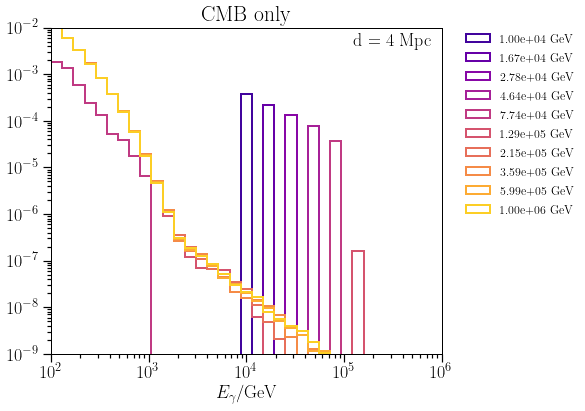

In [71]:
plt.figure(figsize=(7,6))

cm = matplotlib.pyplot.get_cmap('plasma')
N = len(files)
color_min = 0.1
color_max = 0.9
color_range = color_max - color_min
colors = [cm(color_range*i/(N-1)+color_min) for i in range(N)]

eini_range = np.logspace(4,6,10)
distance = 4

for i, filename in enumerate(files_cmb_only):
    x = np.genfromtxt(filename, comments = "#", skip_footer=1)
    if len(x) == 0:
        continue
    #print(x)
    EeV = 1e9
    photo_energies = np.array([xx[2] for xx in x if xx[1] == 22])
    electron_energies = np.array([xx[2] for xx in x if xx[1] == -11])
    plt.hist(photo_energies*EeV, bins = np.logspace(2,6,36),
             histtype="step", lw = 2, density = True, color = colors[i], label = "{Eini:.2e} GeV".format(Eini=eini_range[i]))
plt.text(1.25e5, 4e-3, "d = {distance} Mpc".format(distance=distance))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.semilogy()
plt.semilogx()
plt.xlim(1e2,1e6)
plt.ylim(1e-9,1e-2)
plt.xlabel(r"$E_\gamma$/GeV")
plt.title("CMB only")

Text(0.5, 1.0, 'CMB+IRB')

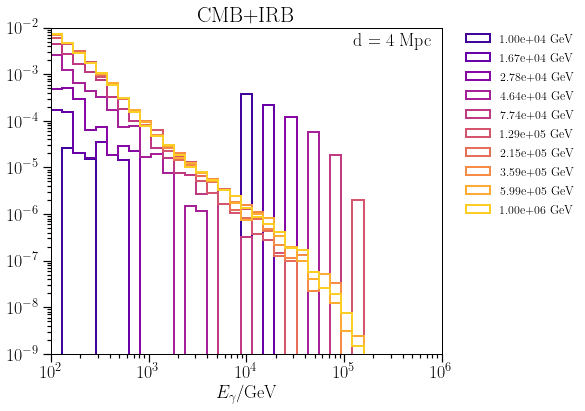

In [72]:
plt.figure(figsize=(7,6))

cm = matplotlib.pyplot.get_cmap('plasma')
N = len(files)
color_min = 0.1
color_max = 0.9
color_range = color_max - color_min
colors = [cm(color_range*i/(N-1)+color_min) for i in range(N)]

eini_range = np.logspace(4,6,10)
distance = 4

for i, filename in enumerate(files_all):
    x = np.genfromtxt(filename, comments = "#", skip_footer=1)
    if len(x) == 0:
        continue
    #print(x)
    EeV = 1e9
    photo_energies = np.array([xx[2] for xx in x if xx[1] == 22])
    electron_energies = np.array([xx[2] for xx in x if xx[1] == -11])
    plt.hist(photo_energies*EeV, bins = np.logspace(2,6,36),
             histtype="step", lw = 2, density = True, color = colors[i], label = "{Eini:.2e} GeV".format(Eini=eini_range[i]))
plt.text(1.25e5, 4e-3, "d = {distance} Mpc".format(distance=distance))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.semilogy()
plt.semilogx()
plt.xlim(1e2,1e6)
plt.ylim(1e-9,1e-2)
plt.xlabel(r"$E_\gamma$/GeV")
plt.title("CMB+IRB")